# Setup

## Import libraries

In [1]:
import glob
from tqdm import tqdm
import datetime
import re
import pandas as pd
import seaborn as sns
import warnings
import os
import pickle
import numpy as np
import utils as ut
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm
import matplotlib.patches as mpatches
import matplotlib
from scipy import stats
import matplotlib.colors as mcolors
import numpy.random as npr
import ssm
from ssm.util import find_permutation
import matplotlib.lines as mlines
npr.seed(0)

## Fetch data

In [2]:
Animal_List = ['QP032', 'QP033', 'QP034','QP049', 'QP050', 
               'QP051', 'QP062', 'QP063', 'QP070', 'QP071', 'QP079']

# Define the path to the cache file
cache_path = '/Users/quentin/Desktop/HeadFixedBehavior/Data/'
cache_file = os.path.join(cache_path, "all_data_cont.pkl")

# Define the path to the figures
figs_path = '/Users/quentin/Desktop/HeadFixedBehavior/Analysis/Figures/'

# Check if the cache file exists
if os.path.exists(cache_file):
    # If the cache file exists, load the data from the cache
    with open(cache_file, "rb") as f:       
        all_data_cont = pickle.load(f)
else:
    # If the cache file does not exist, load the data from the remote server
    all_data_cont = pd.DataFrame()
    for animal in Animal_List:
        try:
            # Load the data for the current animal and add it to the dictionary
            animal_data = ut.get_animal_data('/Volumes/akrami/Quentin/Head_Fixed_Behavior/Data/',
                                             animal, 
                                             'SOUND_CAT_CONT',
                                             'Trial_Summary')
            all_data_cont = pd.concat([all_data_cont, animal_data])
        except:
            # If there is an error loading the data, skip the current animal
            pass

    # Save the data to the cache file
    with open(cache_file, "wb") as f:
        pickle.dump(all_data_cont, f)

## Filter data

In [3]:
data_df = ut.relabel_ELV(all_data_cont) # Re-label appropriately
# TODO: change block removal with date removal
data_df = ut.remove_blocks(data_df, 'QP032', [17, 18]) # blocks with wrong distirbution
data_df = ut.remove_blocks(data_df, 'QP070', [38, 39, 
                                              49
                                              ]) # spout alignment problem
# only keep data where antibias is False or np.nan
data_df = data_df[(data_df.Anti_Bias == False) | (pd.isna(data_df.Anti_Bias))].reset_index(drop=True)
data_df = ut.filter_min_trials(data_df, 100) # Keep at least 100 valid trials per sessions
data_df = ut.threshold_cutoff(data_df, threshold = 0.7) # Only keep sessions where %correct is > threshold

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    data_df = ut.filter_lapses(data_df, threshold = 0.75) # Remove sessions with lapse rates > 20%
    
data_df = ut.add_dist_block(data_df) # Track distribution and mouse specific block_nbs
data_df = ut.check_distributions(data_df, n = 1) # Check thal all subjects have been exposed to all distributions
# data_df = make_blocks_equal(data_df) # Check that all subjects have same number of blocks on each distribution (optional) 
data_df = data_df[data_df['Distribution'].notna()].reset_index(drop=True) # Check distributions are valid
# Ensure thal all blocks follow the desired order (e.g.   ['Uniform', 'Asym_right', 'Asym_left']) (optional)
# data_df = sort_consec_dist(data_df, ['Uniform', 'Asym_right', 'Asym_left']) 

## Set Font Params

In [4]:
ut.set_plot_font(font_family='sans-serif', title_font_size=20, label_font_size=20, sans_serif_font='Helvetica')

In [5]:
# break execution at this cell
raise KeyboardInterrupt("Stopped execution at this cell.")

KeyboardInterrupt: Stopped execution at this cell.

# Figures

## Accuracy & Bias

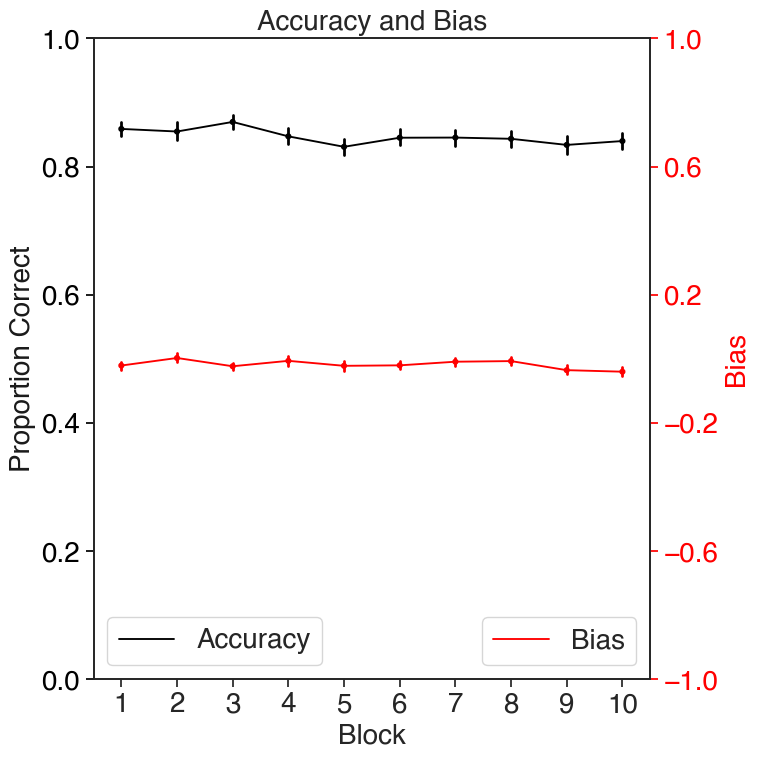

In [ ]:
ut.plot_performance_and_bias_mega_sub(
                                        data_df[data_df.block<10], 
                                        ['QP032', 'QP033', 'QP034',
                                    #  'QP049', 
                                        'QP050', 'QP051', 'QP062', 'QP063', 'QP070', 'QP071', 
                                    #  'QP079'
                                        ], 
                                        save_path = figs_path + 'Accuracy_and_Bias.pdf')

## Psychometric Uniform

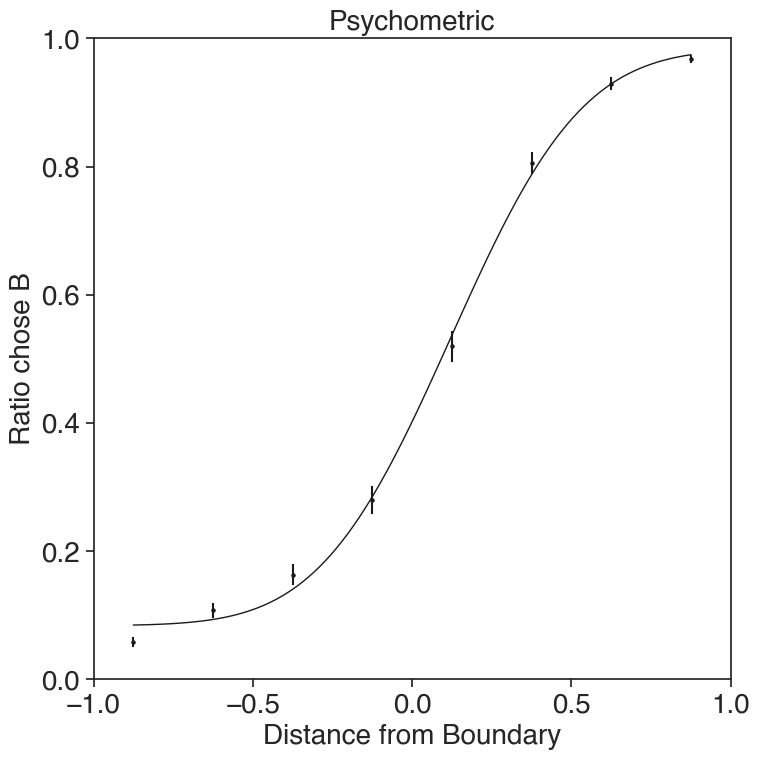

In [ ]:
ut.psycho_plot_mega_sub(df = data_df[data_df.block<10], 
                        participant_ids = [
                                        'QP032', 'QP033', 'QP034', 
                                        # 'QP049' 
                                        'QP050', 'QP051', 'QP062', 'QP063', 'QP070', 'QP071', 
                                        # 'QP079'
                                        ],                     
                        distributions = [
                                        # 'Asym_left', 
                                        # 'Asym_right', 
                                        'Uniform',
                                        ],
                        color_dict = {'Uniform': 'k', 'Asym_left': '#007dc7', 'Asym_right': '#c23f63'},
                        title= 'Psychometric',
                        stim_dur_separate = False,
                        legend = False,
                        save_path = figs_path + 'Psychometric.pdf')

## Psychometric Curves - All Distributions, Cohort 1

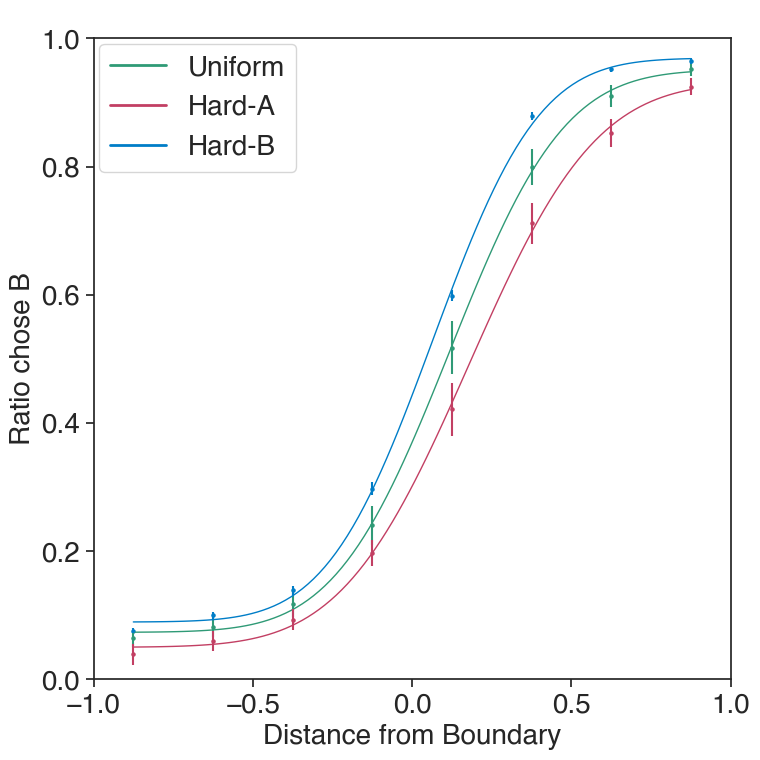

In [ ]:
ut.psycho_plot_mega_sub(
                        df = data_df[(data_df['Distribution'] != 'Asym_right') | (data_df['Stim_Dur'] == 300)].reset_index(drop=True), 
                        participant_ids = ['QP032', 'QP033', 'QP034',
                                          #  'QP049', 
                                           'QP050',
                                           'QP051', 
                                        # 'QP062', 'QP063', 'QP070', 'QP071'
                                        ],                     
                        distributions = [
                                         'Uniform', 
                                         'Asym_right', 
                                         'Asym_left'
                                         ],
                        color_dict = {'Uniform': '#2F9A76', 'Asym_left': '#007dc7', 'Asym_right': '#c23f63'},
                        plot_learning_gradient = False,
                        title= ' ',
                        stim_dur_separate = False,
                        manual_legend = {'Uniform': '#2F9A76', 'Hard-A': '#c23f63', 'Hard-B': '#007dc7'},
                        legend = False,
                        save_path = figs_path + 'Psychometric_All_Dist_Cohort_1.pdf')

## Psychometric Parameters - All Distributions, Cohort 1

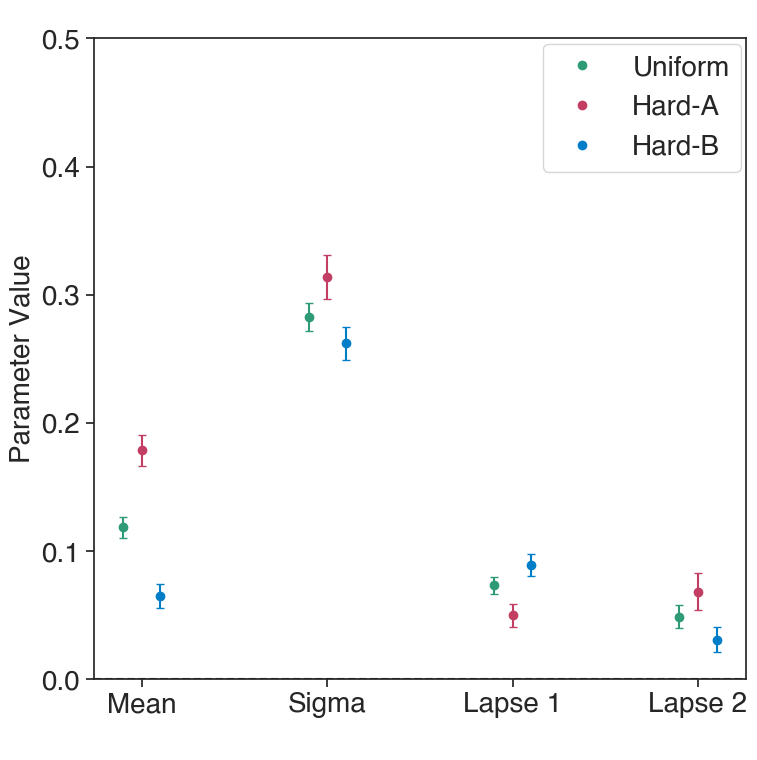

In [ ]:
ut.plot_psycho_params(
                    df = data_df[(data_df['Distribution'] != 'Asym_right') | (data_df['Stim_Dur'] == 300)].reset_index(drop=True), 
                    participant_ids = ['QP032', 'QP033', 'QP034', 'QP050', 'QP051'], 
                    manual_legend = {'Uniform': '#2F9A76', 'Hard-A': '#c23f63', 'Hard-B': '#007dc7'},
                    legend=False,
                    title = ' ',
                    save_path = figs_path + 'Psychometric_Params_Cohort_1.pdf')


## Stim Dur Comp - Cohort 1

### Simulations

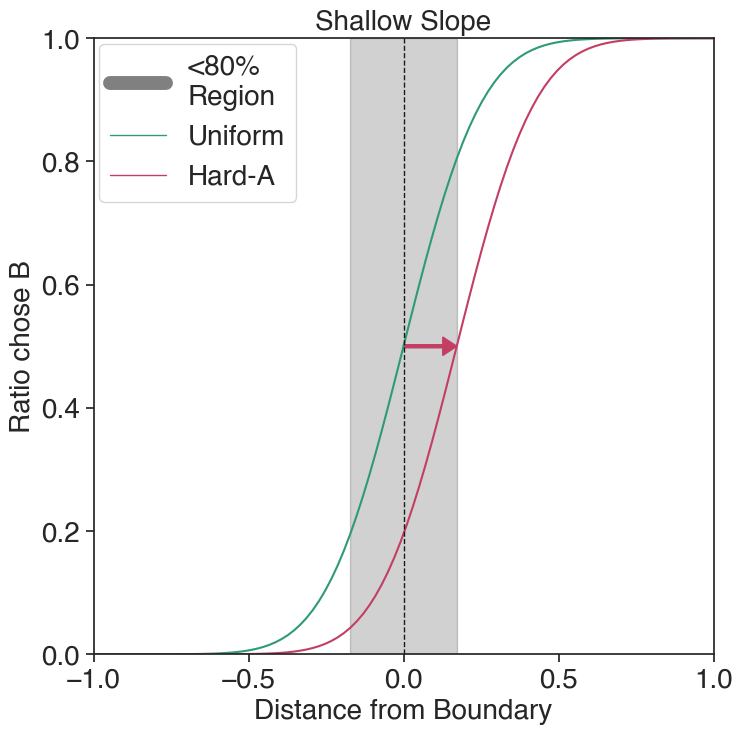

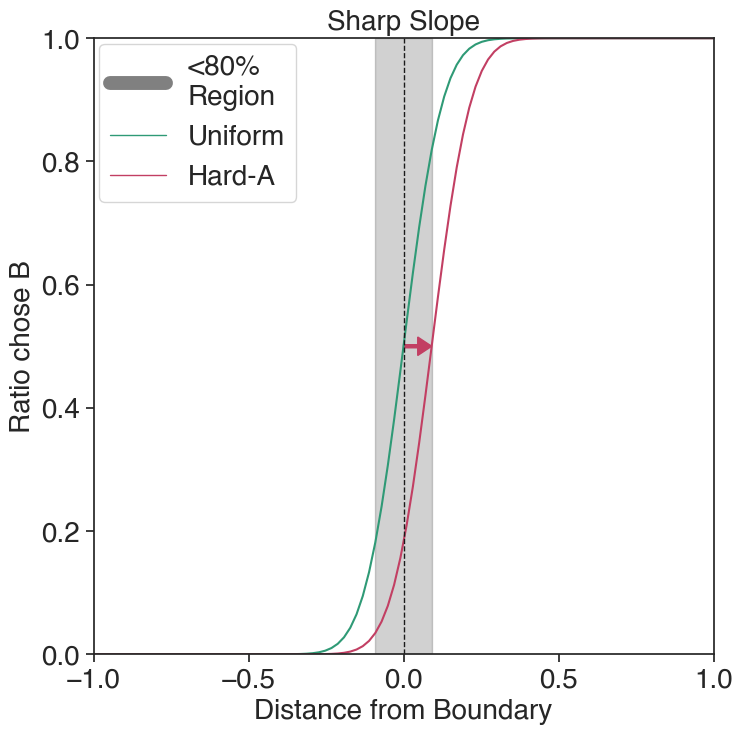

In [ ]:
ut.plot_sim_unif_asymR_shfit(sigma = 0.2, title='Shallow Slope', save_path = figs_path + 'Simulated_Unif_AsymR_Shallow_Slope.pdf')
ut.plot_sim_unif_asymR_shfit(sigma = 0.1, title='Sharp Slope', save_path = figs_path + 'Simulated_Unif_AsymR_Sharp_Slope.pdf')


### Data

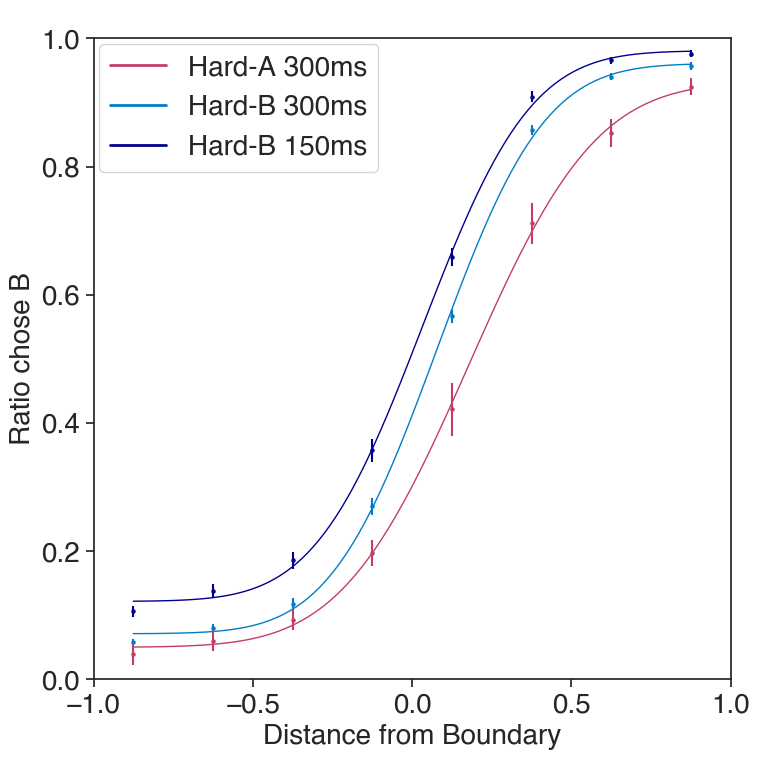

In [ ]:
# remove data where stim_dur is not 300 for asym_right
df = data_df[(data_df['Distribution'] != 'Asym_right') | (data_df['Stim_Dur'] == 300)].reset_index(drop=True)
# remove data where stim_dur is 100,  50 or 0
df = df[(df['Stim_Dur'] != 100) & (df['Stim_Dur'] != 50) & (df['Stim_Dur'] != 0)].reset_index(drop=True)

ut.psycho_plot_mega_sub(df = df, 
                        participant_ids = ['QP032', 'QP033', 'QP034', 
                                        #    'QP049' 
                                           'QP050', 'QP051',
                                        #    'QP063', 'QP070', 'QP071'
                                        ],                     
                        distributions = [
                                         'Asym_left', 
                                         'Asym_right', 
                                       #   'Uniform'
                                         ],
                        color_dict = {
                                      # 'Uniform': ['#00FF00', '#008B00'],
                                      'Asym_left': ['#007dc7', '#00008B'],
                                      'Asym_right': ['#c23f63']},
                        title = ' ',
                        stim_dur_separate = True,
                        manual_legend = {'Hard-A 300ms':'#c23f63', 'Hard-B 300ms': '#007dc7', 'Hard-B 150ms': '#00008B'},
                        legend = False,
                        save_path = figs_path + 'Psychometric_Stim_Dur_Comp.pdf')

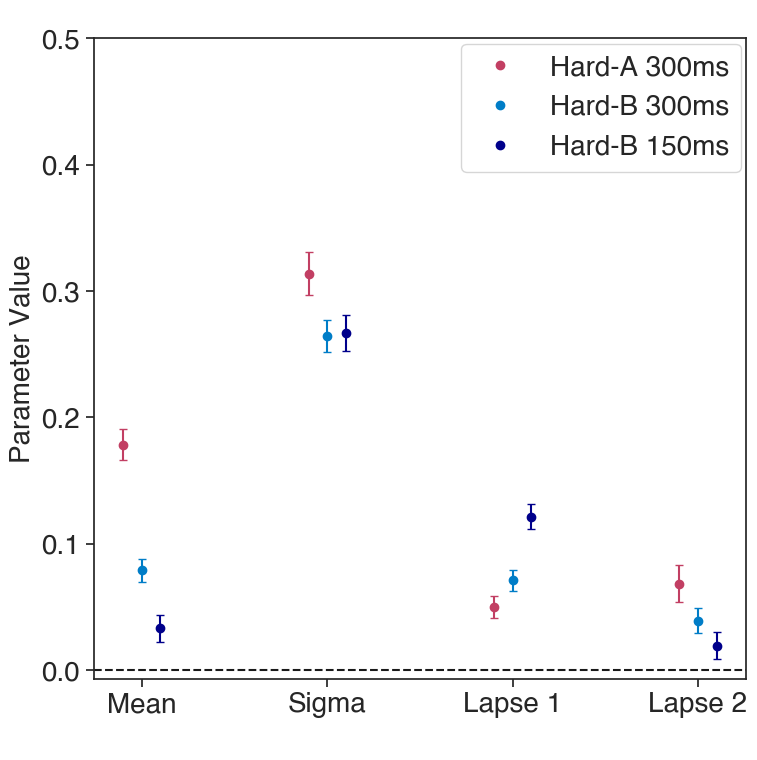

In [ ]:
# remove data where stim_dur is not 300 for asym_right
df = data_df[(data_df['Distribution'] != 'Asym_right') | (data_df['Stim_Dur'] == 300)].reset_index(drop=True)
# remove data where stim_dur is 100,  50 or 0
df = df[(df['Stim_Dur'] != 100) & (df['Stim_Dur'] != 50) & (df['Stim_Dur'] != 0)].reset_index(drop=True)
ut.plot_psycho_params(
                    df = df, 
                    participant_ids = ['QP032', 'QP033', 'QP034', 'QP050', 'QP051'], 
                    distributions=['Asym_left', 'Asym_right'],
                    color_dict = {
                                      'Uniform': ['#00FF00', '#008B00'],
                                      'Asym_left': ['#007dc7', '#00008B'],
                                      'Asym_right': ['#c23f63']},
                    manual_legend = {'Hard-A 300ms':'#c23f63', 'Hard-B 300ms': '#007dc7', 'Hard-B 150ms': '#00008B'},
                    legend=False,
                    title = ' ',
                    stim_dur_separate=True,
                    save_path = figs_path + 'Psychometric_Params_Stim_Dur_Comp.pdf')

## Psychometric Curves - All Distributions, Cohort 2

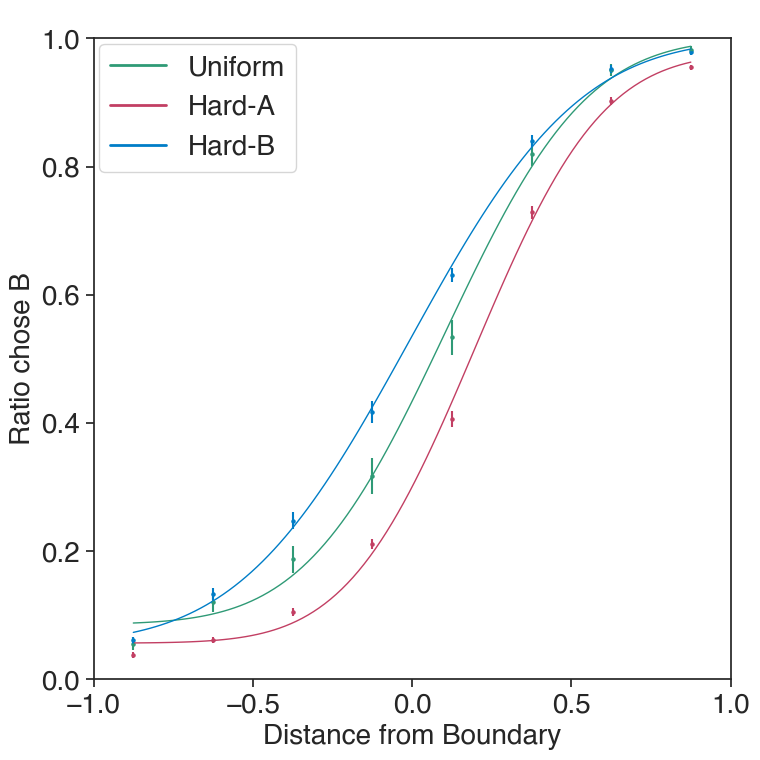

In [ ]:
ut.psycho_plot_mega_sub(
                        df = data_df, 
                        participant_ids = [
                                        #    'QP032', 'QP033', 'QP034',
                                        #   #  'QP049', 
                                        #    'QP050',
                                        #    'QP051', 
                                        'QP062', 'QP063', 'QP070', 'QP071'
                                        ],                     
                        distributions = [
                                         'Uniform', 
                                         'Asym_right', 
                                         'Asym_left'
                                         ],
                        color_dict = {'Uniform': '#2F9A76', 'Asym_left': '#007dc7', 'Asym_right': '#c23f63'},
                        plot_learning_gradient = False,
                        title= ' ',
                        stim_dur_separate = False,
                        manual_legend = {'Uniform': '#2F9A76', 'Hard-A': '#c23f63', 'Hard-B': '#007dc7'},
                        legend = False,
                        save_path = figs_path + 'Psychometric_All_Dist_Cohort_2.pdf')

## Psychometric Parameters - All Distributions, Cohort 2

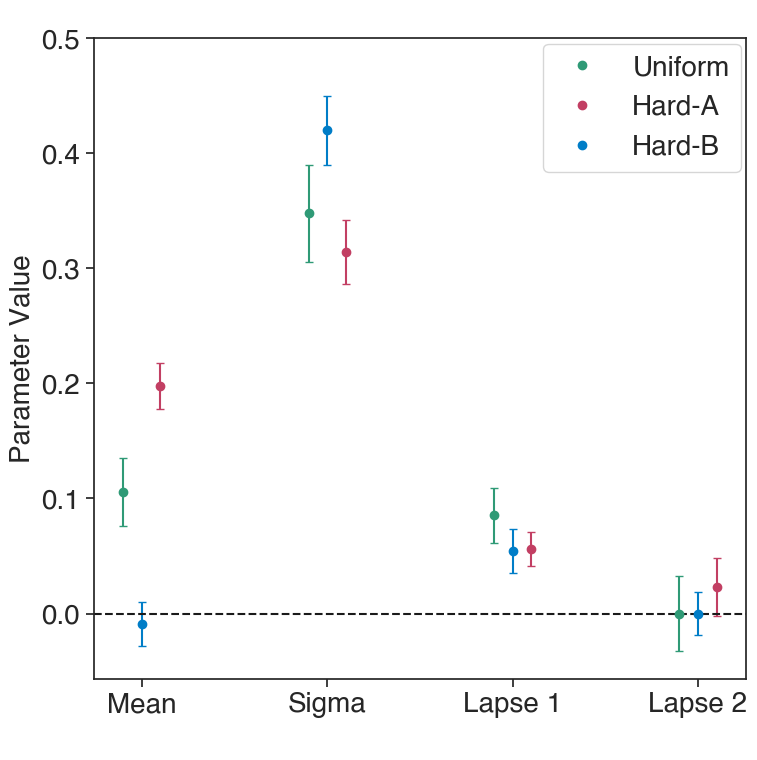

In [ ]:
ut.plot_psycho_params(
                    df = data_df, 
                    participant_ids = [
                                       'QP062', 
                                       'QP063', 'QP070', 'QP071'], 
                    manual_legend = {'Uniform': '#2F9A76', 'Hard-A': '#c23f63', 'Hard-B': '#007dc7'},
                    legend=False,
                    title = ' ',
                    save_path = figs_path + 'Psychometric_Params_Cohort_2.pdf')

## Mean shift Vs Sigma

In [ ]:
psych_params_df = ut.gen_blockwise_psych_params(data_df, ['QP032', 'QP033', 'QP034','QP049', 'QP050',
                                                          'QP051', 'QP062', 'QP063', 'QP070', 'QP071'])  
clean_psych_params_df = psych_params_df[psych_params_df.Block_Means_Std <= 3] # remove outliers

In [ ]:
# add sequence column that tracks the number of distribution switches
clean_psych_params_df = ut.add_dist_sequence_number(clean_psych_params_df)

/Users/quentin/Desktop/HeadFixedBehavior/Analysis/utils.py:1149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_psych_params_df.loc[:, 'Sequence'] = pd.Series(dtype='Int64')


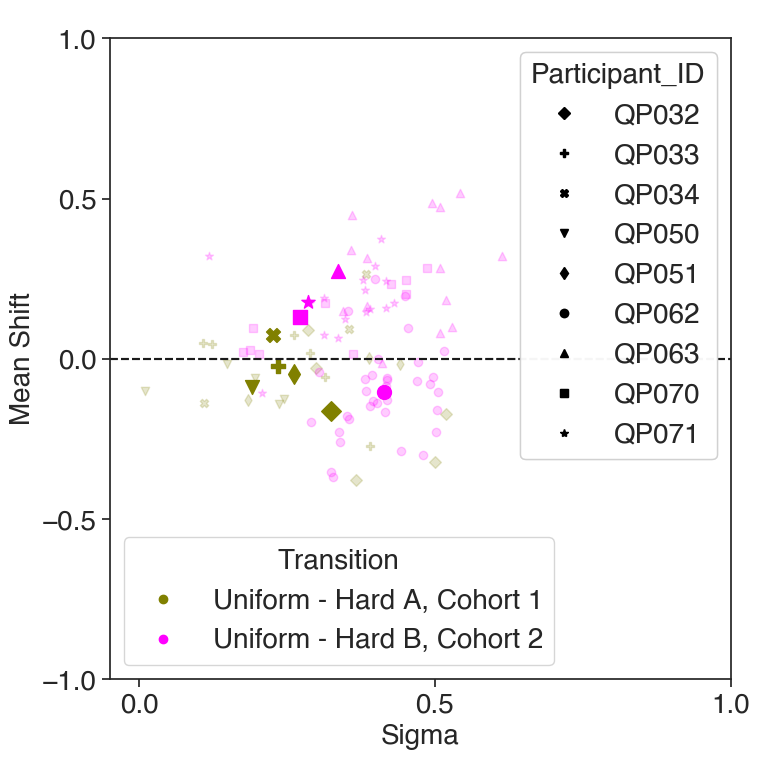

In [ ]:
cohort_dict_1 = {
  'df': clean_psych_params_df,
  'participants': ['QP032', 'QP033', 'QP034', 'QP050', 'QP051'],
  'markers': ['D', 'P', 'X', 'v', 'd'],
  'pre_dist': 'Uniform',
  'post_dist': 'Asym_right',
  'pre_sequence': 0,
  'post_sequence': 0,
  'color': 'olive',
#   'ax': ax,
  'title': ' '
}

cohort_dict_2 = {
  'df': clean_psych_params_df,
  'participants': ['QP062', 'QP063', 'QP070', 'QP071'],
  'markers': ['o', '^', 's', '*'],
  'pre_dist': 'Uniform',
  'post_dist': 'Asym_left',
  'pre_sequence': 0,
  'post_sequence': 0,
  'color': 'magenta',
#   'ax': ax,
  'title': ' '
}

legend = True
save_path = None
manual_legend = {'Uniform - Asym_right': 'Uniform - Hard A, Cohort 1', 'Uniform - Asym_left': 'Uniform - Hard B, Cohort 2'}

ut.plot_mean_shift_Vs_sigma_comp(cohort_dict_1, cohort_dict_2, 
                                 manual_legend=manual_legend,
                                 save_path= figs_path + 'mean_shift_Vs_sigma_comp_first_transition.pdf')


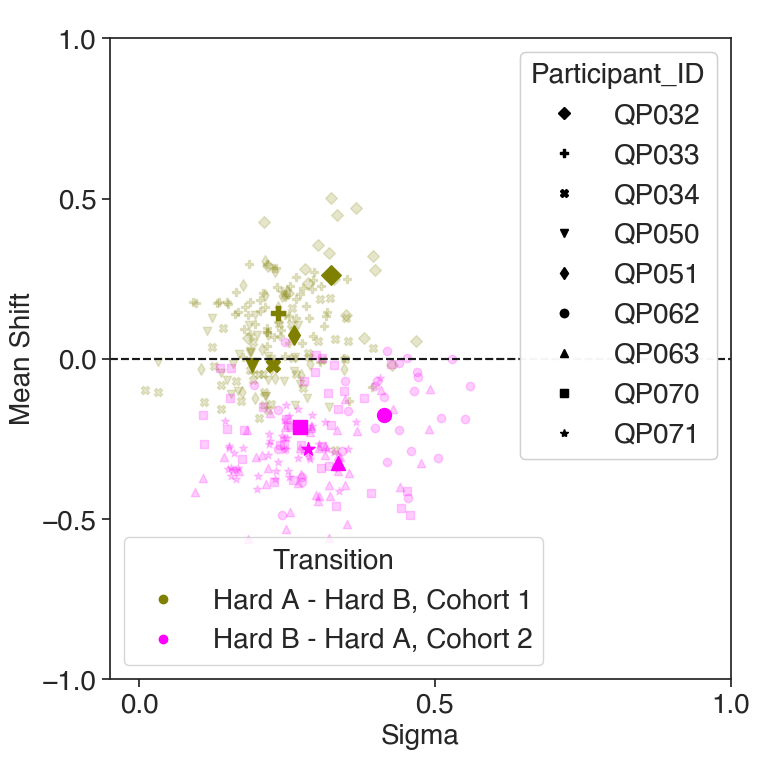

In [ ]:
cohort_dict_1 = {
  'df': clean_psych_params_df,
  'participants': ['QP032', 'QP033', 'QP034', 'QP050', 'QP051'],
  'markers': ['D', 'P', 'X', 'v', 'd'],
  'pre_dist': 'Asym_right',
  'post_dist': 'Asym_left',
  'pre_sequence': 0,
  'post_sequence': 0,
  'color': 'olive',
#   'ax': ax,
  'title': ' '
}

cohort_dict_2 = {
  'df': clean_psych_params_df,
  'participants': ['QP062', 'QP063', 'QP070', 'QP071'],
  'markers': ['o', '^', 's', '*'],
  'pre_dist': 'Asym_left',
  'post_dist': 'Asym_right',
  'pre_sequence': 0,
  'post_sequence': 0,
  'color': 'magenta',
#   'ax': ax,
  'title': ' '
}

legend = True
save_path = None
manual_legend = {'Asym_right - Asym_left': 'Hard A - Hard B, Cohort 1', 'Asym_left - Asym_right': 'Hard B - Hard A, Cohort 2'}

ut.plot_mean_shift_Vs_sigma_comp(cohort_dict_1, cohort_dict_2, 
                                 manual_legend=manual_legend,
                                 save_path= figs_path + 'mean_shift_Vs_sigma_comp_second_transition.pdf')

## GML-HMM

In [ ]:
# Set the parameters of the GLM-HMM
num_states = 3       # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 2         # input dimensions

glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")
color_dict = {0: '#ff7f00', 1: '#4daf4a', 2: '#377eb8'}

In [ ]:
inpts, choices, animal_df = ut.format_data_hmmglm(data_df, 
                                                  'QP070', 
                                                  input_dim = input_dim)

In [ ]:
N_iters = 1000 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll = glmhmm.fit(choices, inputs=inpts, method="em", num_iters=N_iters, tolerance=10**-4)

  0%|          | 0/1000 [00:00<?, ?it/s]

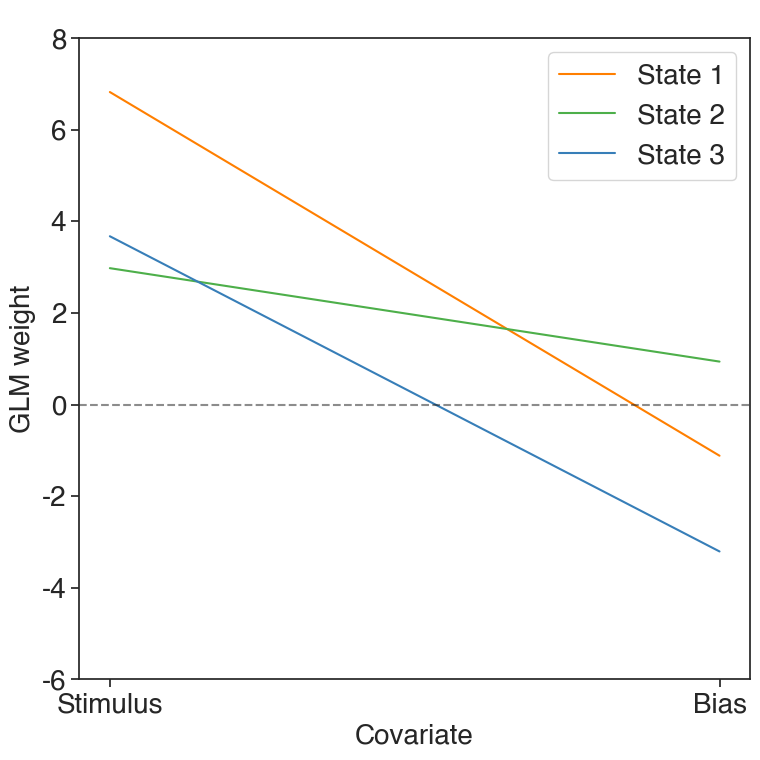

In [ ]:
ut.plot_glmhmm_weights(glmhmm, num_states = num_states, input_dim = input_dim, color_dict = color_dict,
                       save_path = figs_path + 'GLMHMM_weights.pdf')

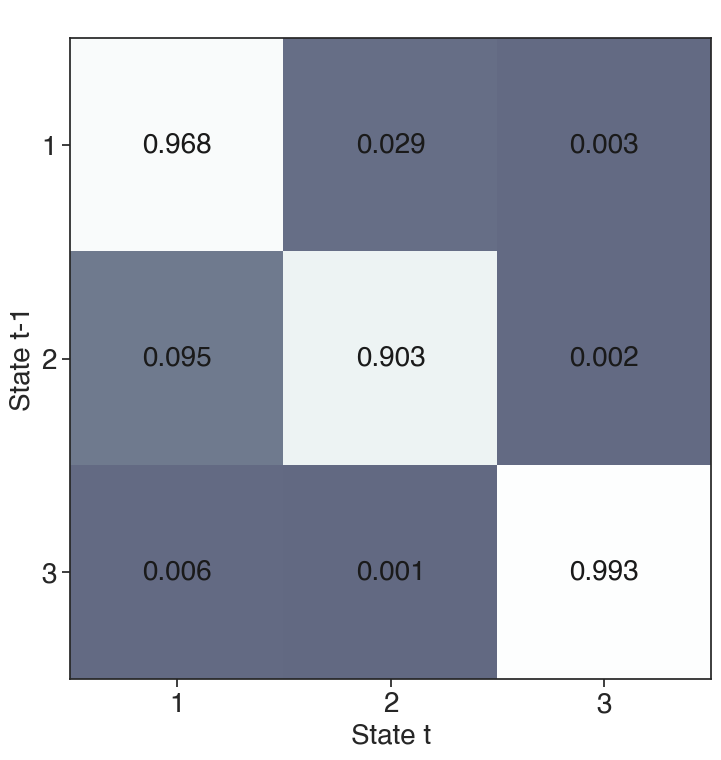

In [ ]:
ut.plot_glmhmm_trans_mat(glmhmm, num_states = num_states, decimals = 3, 
                         save_path = figs_path + 'GLMHMM_trans_mat.pdf')

In [ ]:
# Get expected states:
posterior_probs = [glmhmm.expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip(choices, inpts)]

In [ ]:
# concatenate posterior probabilities across sessions
posterior_probs_concat = np.concatenate(posterior_probs)
# get state with maximum posterior probability at particular trial:
state_max_posterior = np.argmax(posterior_probs_concat, axis = 1)
# now obtain state fractional occupancies:
_, state_occupancies = np.unique(state_max_posterior, return_counts=True)
state_occupancies = state_occupancies/np.sum(state_occupancies)
# add state_max_posterior to animal_df

animal_df['state'] = state_max_posterior

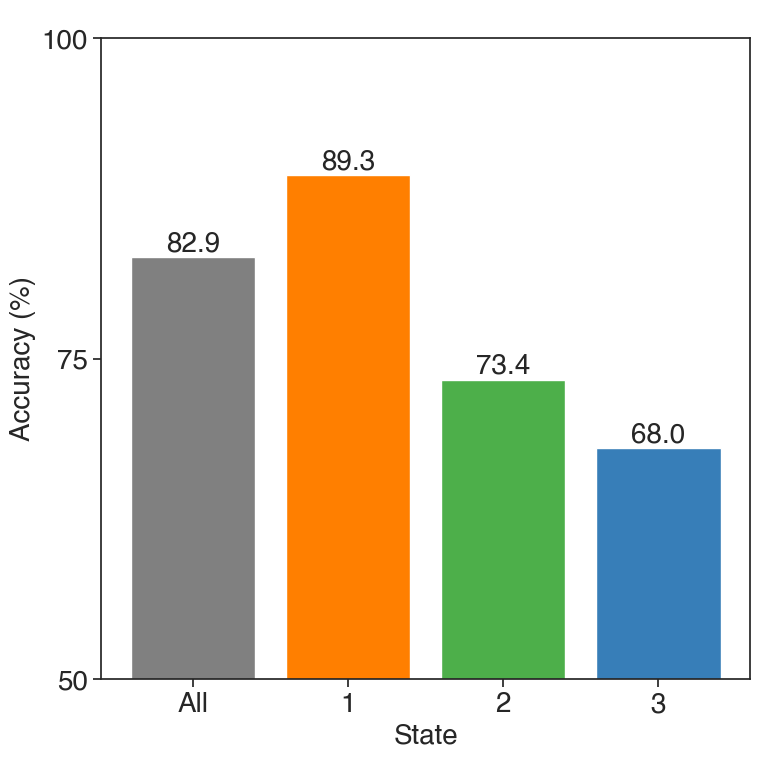

In [ ]:
ut.plot_accuracy_by_state(animal_df, num_states = num_states, color_dict = color_dict,
                          save_path = figs_path + 'GLMHMM_accuracy_by_state.pdf')


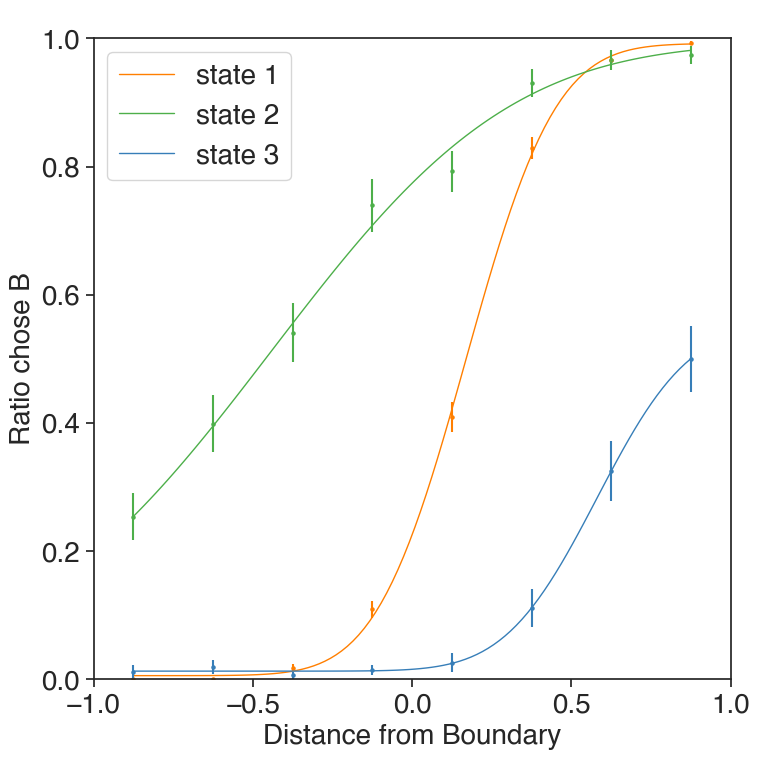

In [ ]:
ut.plot_psycho_by_state(animal_df, num_states, color_dict, 
                        save_path = figs_path + 'GLMHMM_psycho_by_state.pdf')

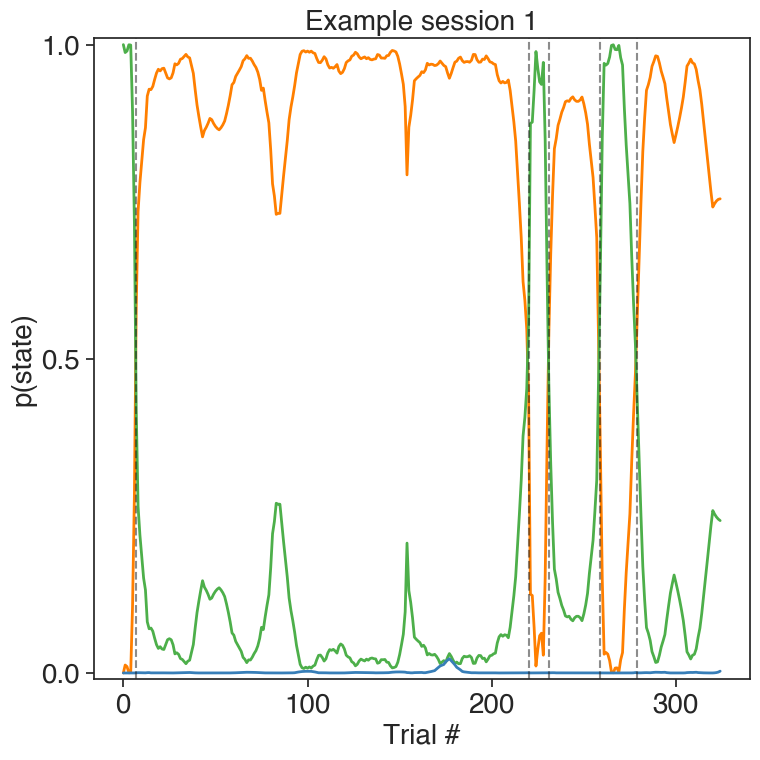

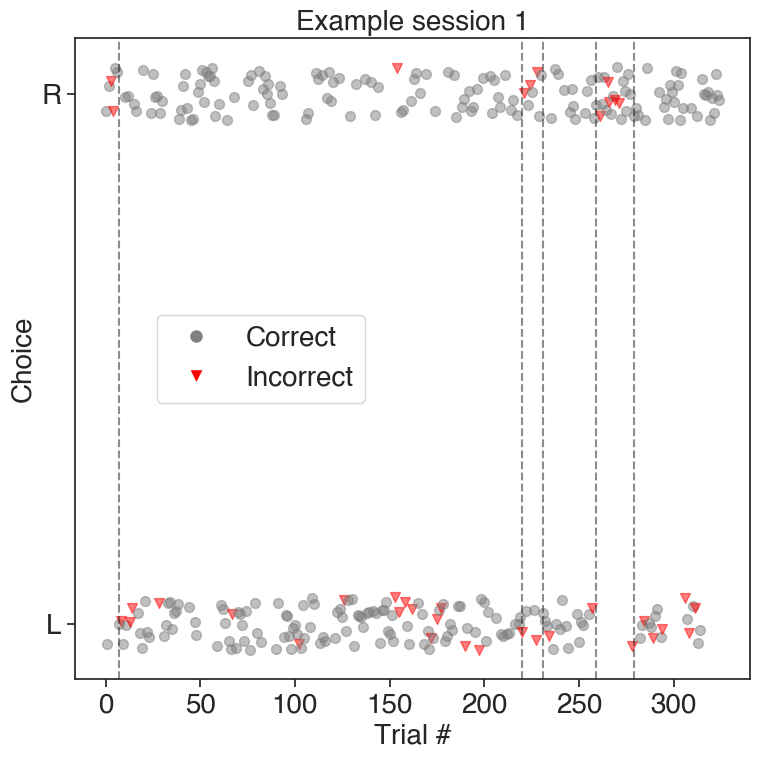

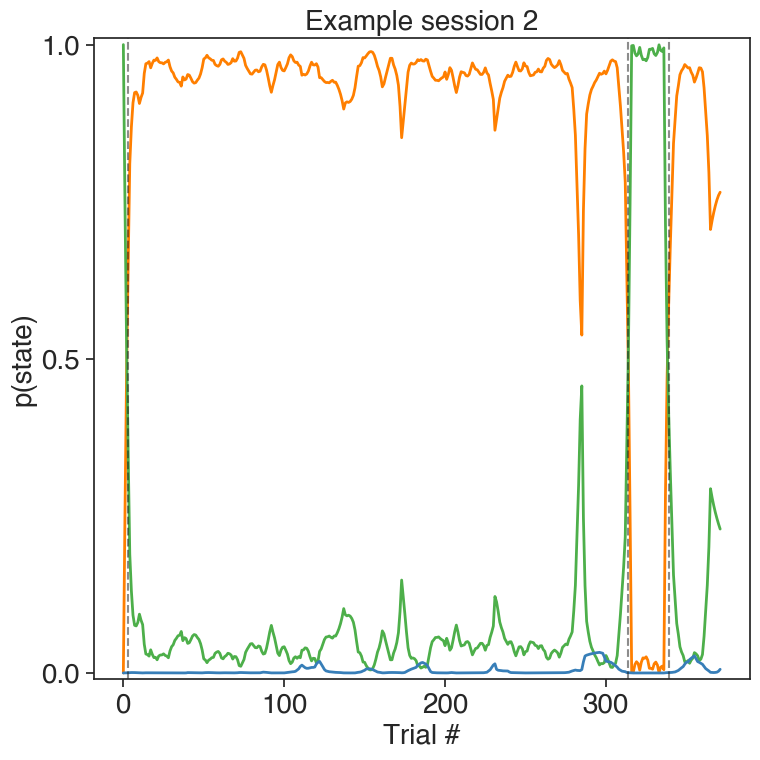

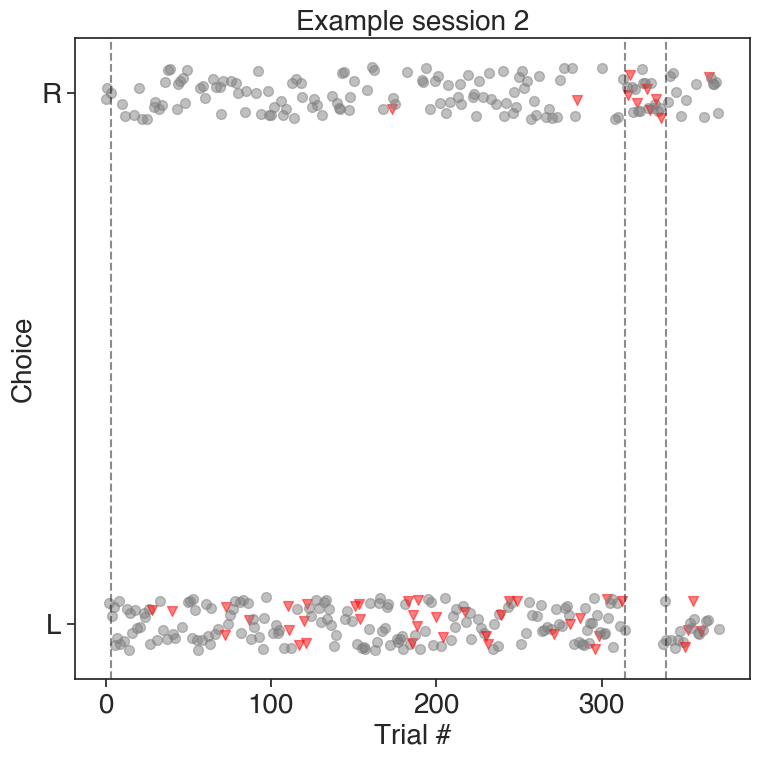

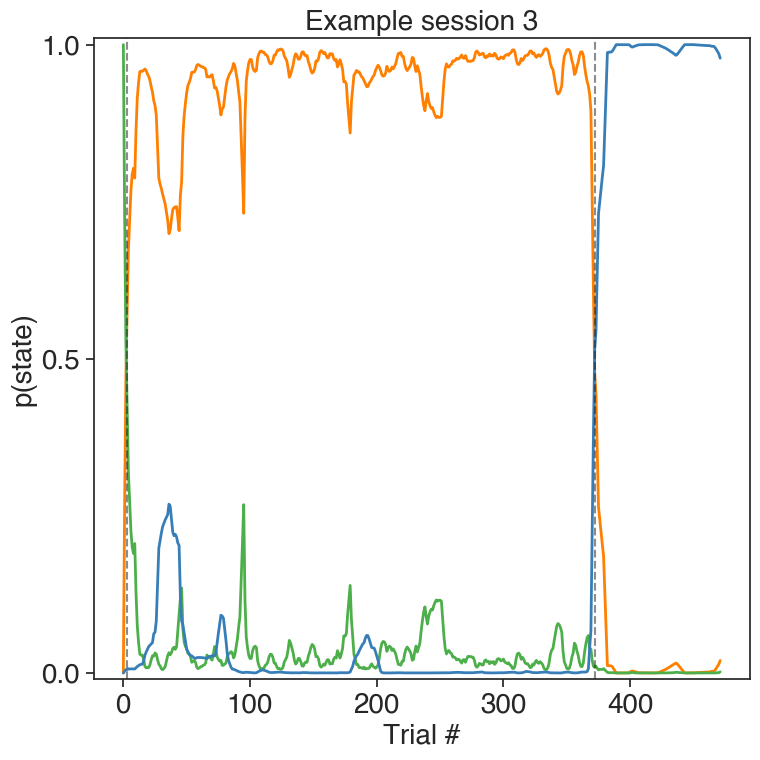

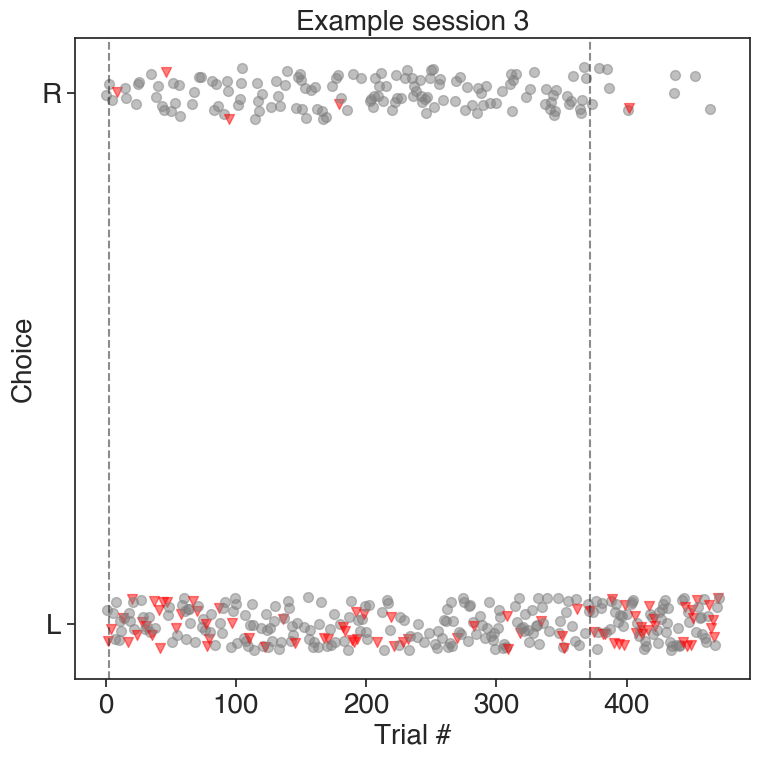

In [ ]:
egg_sess_ids = [3,4,27]

for i, sess_id in zip(range(len(egg_sess_ids)), egg_sess_ids):
    ut.plot_state_probabilities(posterior_probs, sess_id, num_states, color_dict, title='Example session ' + str(i+1),
                                legend_bbox = None,
                                save_path = figs_path + 'GLMHMM_state_probabilities_' + str(i+1) + '.pdf')
    
    if i == 0:
        ut.plot_choice_scatter(animal_df, posterior_probs, sess_id, title='Example session ' + str(i+1), 
                           legend_bbox = (0.25, 0.4, 0.2, 0.2),
                           save_path= figs_path + 'GLMHMM_choice_scatter_' + str(i+1) + '.pdf')
    else:
        ut.plot_choice_scatter(animal_df, posterior_probs, sess_id, title='Example session ' + str(i+1), 
                           legend_bbox = None,
                           save_path= figs_path + 'GLMHMM_choice_scatter_' + str(i+1) + '.pdf')

In [ ]:
# # plot_state_probabilities for all sessions
# for sess_id in range(len(posterior_probs)):
#     ut.plot_state_probabilities(posterior_probs, sess_id, num_states, color_dict, title='Session ' + str(sess_id),
#                                 legend_bbox = (0.62, 0.4, 0.2, 0.2),
#                                 save_path = None)


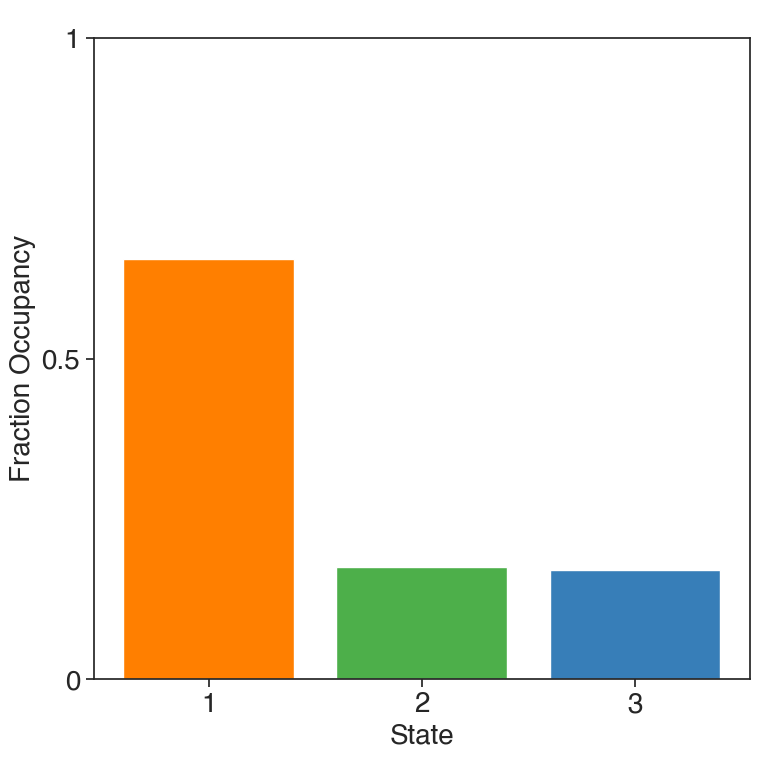

In [ ]:
ut.plot_frac_state_occupancies(state_occupancies = state_occupancies, 
                               num_states = 3, 
                               color_dict = color_dict, 
                               save_path = figs_path + 'GLMHMM_frac_state_occupancies.pdf')

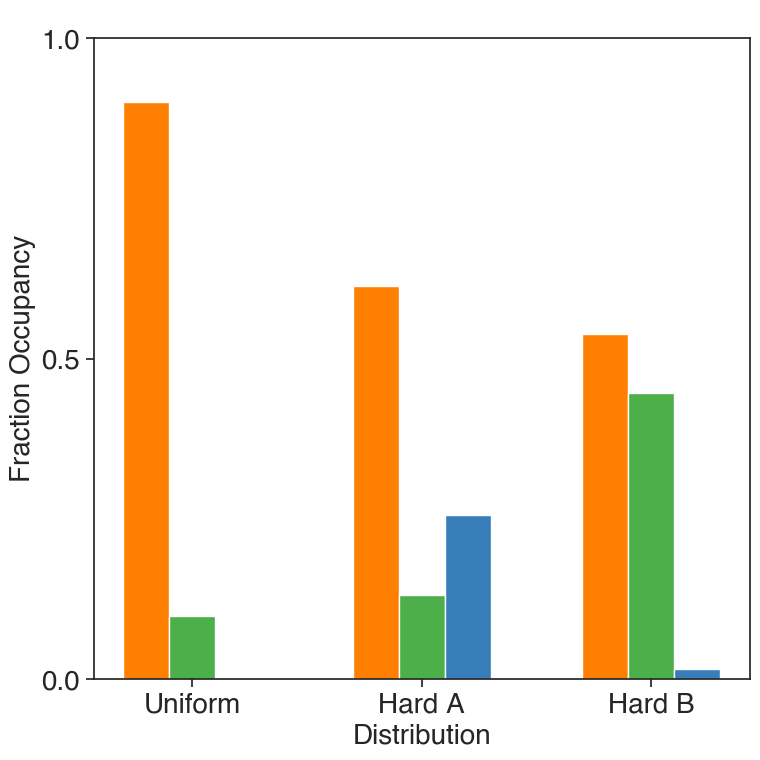

In [ ]:
ut.plot_state_occ_by_dist(animal_df, 
                       distribution_order = ['Uniform', 'Asym_right', 'Asym_left'],
                        color_dict = color_dict, 
                        distribution_dict = {'Uniform': 'Uniform', 'Asym_left': 'Hard B', 'Asym_right': 'Hard A'},
                        save_path= figs_path + 'GLMHMM_state_occ_by_dist.pdf')


## Update Matrix

In [6]:
# apply the add_previous_trial_data to each group
data_df = data_df.groupby('Participant_ID', group_keys=False).apply(ut.add_previous_trial_data)

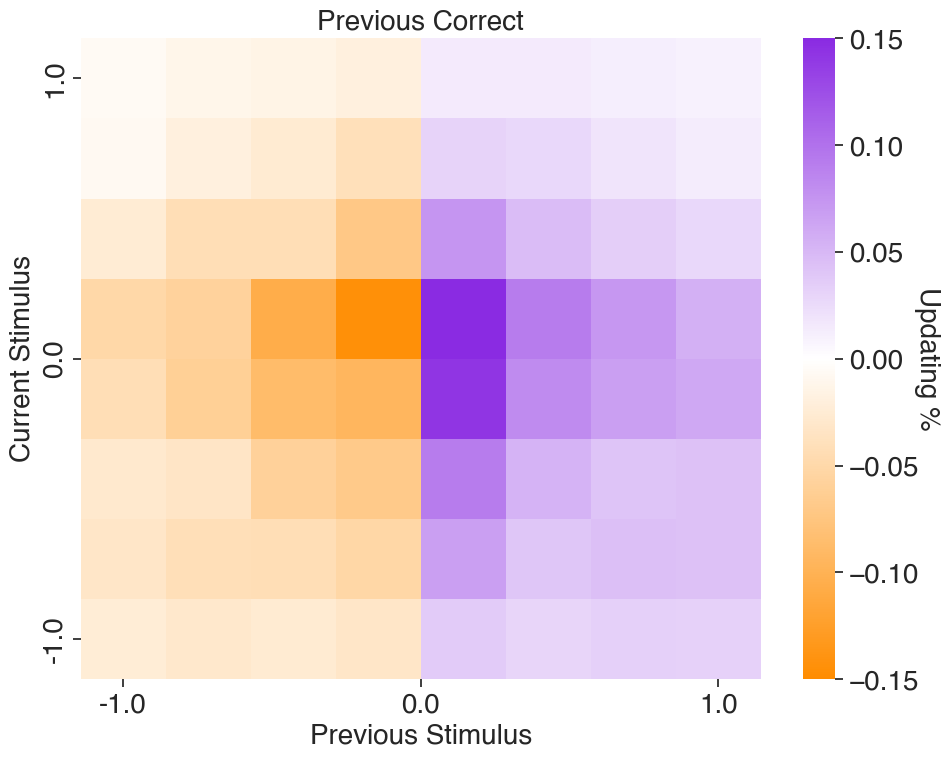

In [8]:
# only get update matrix for certain animals
df = data_df[data_df.Participant_ID.isin(['QP033', 'QP034', 'QP050', 'QP051', 
                                          'QP062', 'QP063', 'QP070', 'QP071', 'QP079'])]
ut.plot_update_matrix(ut.compute_update_matrix(df, prev_correct=True),
                                                   title = 'Previous Correct',
                                                   save_path = figs_path + 'update_matrix_prev_correct.pdf')